<a href="https://colab.research.google.com/github/tshanedc/bikesharing_finalproject/blob/main/weekly_casual_rides_pmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Dependencies
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from fbprophet import Prophet
import warnings;
warnings.simplefilter('ignore') 
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load data
data = '/content/drive/MyDrive/Colab Notebooks/member_rides.csv'
#df_train= pd.read_csv(data)
#file_path = Path('./Resources/Data/member_rides.csv')
member_rides_df = pd.read_csv(data)
member_rides_df.head(10)

,ds,y
0,2010-09-20 11:27:04,1
1,2010-09-20 11:41:22,1
2,2010-09-20 12:05:37,1
3,2010-09-20 12:06:05,1
4,2010-09-20 12:10:43,1
5,2010-09-20 12:14:27,1
6,2010-09-20 12:15:26,1
7,2010-09-20 12:16:36,1
8,2010-09-20 12:18:38,1
9,2010-09-20 12:19:46,1


In [4]:
member_rides_df.dtypes

ds    object
y      int64
dtype: object

In [5]:
member_rides_df['y'].value_counts()

1    22126756
0     6269130
Name: y, dtype: int64

In [6]:
# Remove 'Member-1' from 'y' column
casual_rides_df = member_rides_df[member_rides_df.y != 1]

In [7]:
casual_rides_df['y'].value_counts()

0    6269130
Name: y, dtype: int64

In [8]:
# Convert 'ds' object to datetime object 
casual_rides_df['ds'] = pd.to_datetime(casual_rides_df['ds'])

In [9]:
casual_rides_df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

In [10]:
casual_rides_df.head()

,ds,y
32,2010-09-20 14:28:39,0
33,2010-09-20 14:45:13,0
41,2010-09-20 15:29:26,0
45,2010-09-20 15:43:10,0
48,2010-09-20 16:17:02,0


In [12]:
# Limit dates to 2010-2019
casual_pre2020 = casual_rides_df[casual_rides_df['ds'] <= '2019-12-31']
casual_pre2020.head(5) 

,ds,y
32,2010-09-20 14:28:39,0
33,2010-09-20 14:45:13,0
41,2010-09-20 15:29:26,0
45,2010-09-20 15:43:10,0
48,2010-09-20 16:17:02,0


In [23]:
casual_pre2020.shape

(5366097, 2)

In [24]:
# Convert y column zeros to ones ----- df['a'] = np.where((df.a < 0), 0, df.a)  --- https://pythonexamples.org/pandas-dataframe-replace-values-in-column-based-on-condition/
import numpy as np
casual_pre2020['y'] = np.where((casual_pre2020.y <=0), 1, casual_pre2020.y)
casual_pre2020.head()

,ds,y
32,2010-09-20 14:28:39,1
33,2010-09-20 14:45:13,1
41,2010-09-20 15:29:26,1
45,2010-09-20 15:43:10,1
48,2010-09-20 16:17:02,1


In [25]:
# Create Weekly bins
#df1 = df.resample('M', on='Date').sum()  --- https://www.youtube.com/watch?v=l4dvMiSDBzs
casualxweek_df = casual_pre2020.resample('w', on='ds').sum()
casualxweek_df.head(5)

,y
ds,
2010-09-26,1037
2010-10-03,1044
2010-10-10,1809
2010-10-17,2351
2010-10-24,2463


In [26]:
casualxweek_df.shape

(485, 1)

In [27]:
# Create new column from 'index'
casualxweek_df.reset_index(inplace=True)
casualxweek_df = casualxweek_df.rename(columns = {'ds':'ds'})
casualxweek_df.head()

,ds,y
0,2010-09-26,1037
1,2010-10-03,1044
2,2010-10-10,1809
3,2010-10-17,2351
4,2010-10-24,2463


In [28]:
casualxweek_df.shape

(485, 2)

In [29]:
casualxweek_df.dtypes

ds    datetime64[ns]
y              int64
dtype: object

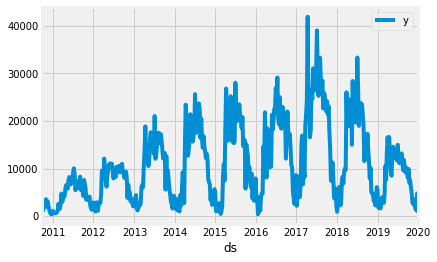

In [30]:
casualxweek_df.plot(x='ds', y='y')

In [34]:
# Create a train dataframe
train = casualxweek_df[casualxweek_df['ds'] <= '2017-12-31']
train.head(5)

,ds,y
0,2010-09-26,1037
1,2010-10-03,1044
2,2010-10-10,1809
3,2010-10-17,2351
4,2010-10-24,2463


In [35]:
train.shape

(380, 2)

In [36]:
# Crete a test dataframe
test = casualxweek_df[casualxweek_df['ds'] >= '2017-12-31']

In [37]:
test.head()

,ds,y
379,2017-12-31,2070
380,2018-01-07,909
381,2018-01-14,3152
382,2018-01-21,5816
383,2018-01-28,6155


In [38]:
test.tail()

,ds,y
480,2019-12-08,2133
481,2019-12-15,1430
482,2019-12-22,1251
483,2019-12-29,4770
484,2020-01-05,724


In [39]:
print(f"Number of months in train data: {len(train)}")
print(f"Number of months in test data: {len(test)}")

Number of months in train data: 380
Number of months in test data: 106


In [41]:
# Instantiate and fit the Prophet model 
m = Prophet(interval_width=0.95, weekly_seasonality=True, changepoint_range=0.9)
model = m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# Set parameters for predictions
casual_weekly_future_data = model.make_future_dataframe(periods=106, freq='w')
casual_weekly_future_data.tail()

,ds
481,2019-12-15
482,2019-12-22
483,2019-12-29
484,2020-01-05
485,2020-01-12


In [48]:
# Make predictions
casual_weekly_forecast_data = model.predict(casual_weekly_future_data)

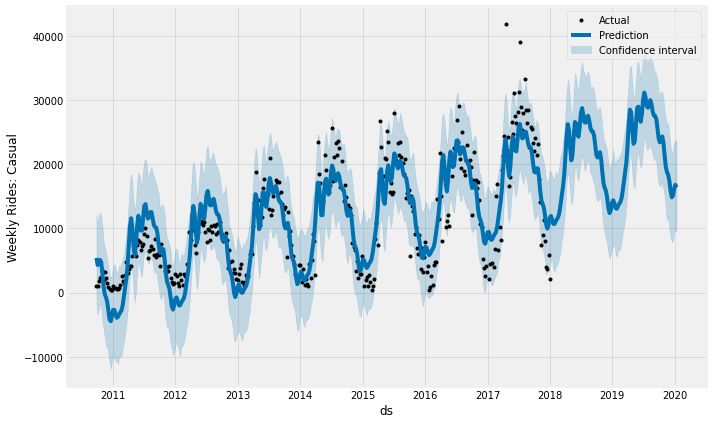

In [62]:
# Prophet's own plotting tool to see 
casual_weekly_predict_fig = m.plot(casual_weekly_forecast_data)
plt.ylabel('Weekly Rides: Casual')
plt.legend(['Actual', 'Prediction', 'Confidence interval'])
plt.show()

In [50]:
# Check components
casual_weekly_forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
481,2019-12-15,14849.139519,7889.594977,21810.383659
482,2019-12-22,15139.870615,8092.638080,22074.404859
483,2019-12-29,16193.104147,9562.351295,23397.189779
484,2020-01-05,16796.649835,9680.540655,23741.228681
485,2020-01-12,16424.280697,9662.826818,23722.176496


In [51]:
casual_weekly_forecast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-09-26,1778.289134,-1638.987578,12226.006798,1778.289134,1778.289134,3625.459851,3625.459851,3625.459851,2228.279973,2228.279973,2228.279973,1397.179878,1397.179878,1397.179878,0.0,0.0,0.0,5403.748985
1,2010-10-03,1812.397355,-3417.256194,10859.235414,1812.397355,1812.397355,2485.676808,2485.676808,2485.676808,2228.279973,2228.279973,2228.279973,257.396835,257.396835,257.396835,0.0,0.0,0.0,4298.074162
2,2010-10-10,1846.505575,-2721.230926,11818.963532,1846.505575,1846.505575,2625.323327,2625.323327,2625.323327,2228.279973,2228.279973,2228.279973,397.043354,397.043354,397.043354,0.0,0.0,0.0,4471.828902
3,2010-10-17,1880.613796,-1599.041255,12510.881466,1880.613796,1880.613796,3210.101495,3210.101495,3210.101495,2228.279973,2228.279973,2228.279973,981.821522,981.821522,981.821522,0.0,0.0,0.0,5090.715291
4,2010-10-24,1914.722017,-2250.526732,11991.414927,1914.722017,1914.722017,2804.772282,2804.772282,2804.772282,2228.279973,2228.279973,2228.279973,576.492310,576.492310,576.492310,0.0,0.0,0.0,4719.494299


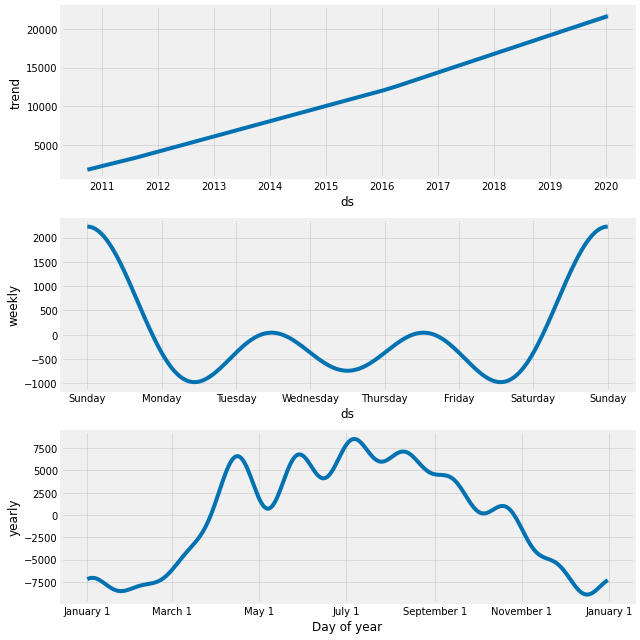

In [74]:
# Decompose outputs
casual_weekly_fig = model.plot_components(casual_weekly_forecast_data)

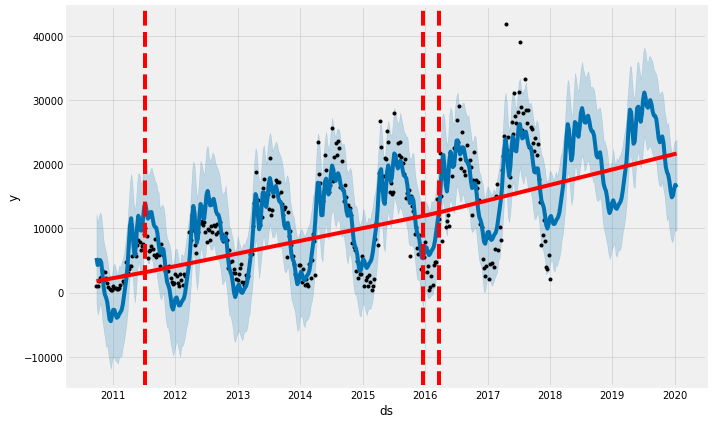

In [53]:
# Plot changepoints
from fbprophet.plot import add_changepoints_to_plot
casual_weekly_cp_fig = m.plot(casual_weekly_forecast_data)
a = add_changepoints_to_plot(casual_weekly_cp_fig.gca(), m, casual_weekly_forecast_data)

In [54]:
deltas = m.params['delta'].mean(0)
deltas

array([ 5.32822417e-09,  8.17391066e-07,  3.29161734e-02,  9.27119610e-07,
       -1.37668804e-09,  1.26664209e-08,  2.84976091e-08,  2.56607698e-08,
        5.55428479e-09, -3.60761958e-09,  3.50975201e-09, -8.82042073e-09,
        1.12711820e-08,  8.19877703e-09,  9.96173043e-09,  7.02539719e-10,
        4.52604559e-08,  1.91333488e-08,  3.78462981e-05,  3.56101668e-02,
        4.06507152e-02,  1.88135477e-04, -1.02653958e-08,  7.39317181e-09,
       -2.97946260e-10])

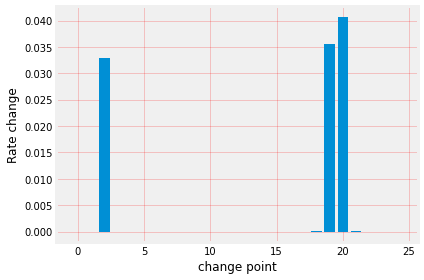

In [58]:
# Plot changepoint changes
fig= plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='red', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('change point')
fig.tight_layout()

In [59]:
# Cross Validation
from fbprophet.diagnostics import cross_validation
casual_weekly_cv_results = cross_validation(model=m, initial='366', horizon='180 days', parallel='processes')
casual_weekly_cv_results.head()

INFO:fbprophet:Making 28 forecasts with cutoffs between 2010-11-08 00:00:00 and 2017-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbec4ad7410>
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 17.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-11-14,-12575.177113,-12690.972292,-12467.065482,3154,2010-11-08
1,2010-11-21,-45498.791295,-45800.015260,-45201.644678,2301,2010-11-08
2,2010-11-28,-84112.499614,-84639.441000,-83566.999985,1537,2010-11-08
3,2010-12-05,-101917.364527,-102691.891468,-101116.855011,844,2010-11-08
4,2010-12-12,-83452.402097,-84506.818017,-82328.081618,522,2010-11-08


In [60]:
# Performance Metrics
from fbprophet.diagnostics import performance_metrics
casual_weekly_pm = performance_metrics(casual_weekly_cv_results)
casual_weekly_pm

,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,8.636463e+07,9293.257455,5374.848483,1.409981,0.306067,0.541667
1,19 days,8.659639e+07,9305.718251,5407.852897,1.440449,0.306067,0.555556
2,20 days,1.880306e+08,13712.426395,6489.260958,2.270888,0.303213,0.555556
3,21 days,1.883299e+08,13723.332473,6499.494046,2.240332,0.317077,0.541667
4,22 days,2.177215e+08,14755.390276,7095.844160,2.319927,0.328672,0.527778
...,...,...,...,...,...,...,...
158,176 days,9.644673e+07,9820.729568,5495.918137,1.200114,0.240886,0.569444
159,177 days,9.819299e+07,9909.237618,5623.249638,1.237608,0.240886,0.555556
160,178 days,4.370420e+07,6610.915416,4830.555502,1.033387,0.245353,0.555556
161,179 days,4.266158e+07,6531.583050,4753.779571,1.036344,0.240886,0.569444
